# Porous convection

initial value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\phi\frac{\partial c}{\partial t} + \textbf{u}\cdot\nabla c = \frac{1}{Ra}\nabla\cdot(\mathsf{D}\cdot\nabla c)$$

$$\nabla\cdot\textbf{u}=0$$

$$\textbf{u}=-\frac{\mathsf{K}}{\mu}\cdot(\nabla p + \rho\,\textbf{e}_g)$$

Dirichlet boundary condition on $\textbf{x}\in\partial\Omega_{\text{D}}$

$$c = c_{\text{D}}$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}$

$$\textbf{n}\cdot\nabla(\mathsf{D}\cdot c) = c_{\text{N}}$$
essential boundary condition on $\textbf{x}\in\partial\Omega_E$

$$\textbf{n}\cdot\textbf{u} = u_{\text{E}}$$

natural boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{E}}$

$$p = p_{\text{N}}$$

constitutive relations

$$
\begin{align*}
\phi & =\phi(\textbf{x}) \\
\mathsf{D} &= \mathsf{D}(\phi, \textbf{u}) \\ 
\mathsf{K} &= \mathsf{K}(\phi) \\ 
\mu &= \mu(c) \\
\rho &= \rho(c)
\end{align*}
$$

$d=2$ Cartesian streamfunction formulation

$$\phi\frac{\partial c}{\partial t} + \textbf{u}\cdot\nabla c = \frac{1}{Ra}\nabla\cdot(\mathsf{D}\cdot\nabla c)$$

$$\textbf{u} =-\frac{\partial\psi}{\partial y}\textbf{e}_x + \frac{\partial\psi}{\partial x}\textbf{e}_y$$

$$\nabla\cdot\left(\frac{\mu\mathsf{K}^{\mathsf{T}}\cdot\nabla\psi}{\text{det}(\mathsf{K})}\right)=\frac{\partial(e_{g}^{y}\rho)}{\partial x} - \frac{\partial(e_{g}^{x}\rho)}{\partial y}$$

$$\textbf{e}_g = e_{g}^{x}\,\textbf{e}_x + e_{g}^{y}\,\textbf{e}_y~,~(e_{g}^{x})^2 + (e_{g}^{y})^2=1$$

## $d=2$ Rayleigh-Benard convection example

$$\Omega = [0, L_x] \times [0, L_y]$$

$$c(x,y,t=0)=1-y+\mathcal{N}(x,y)$$

$$c(x,y=0)=1$$

$$c(x,y=L_y)=0$$

$$\frac{\partial c}{\partial x}\bigg\vert_{x=0,y}=\frac{\partial c}{\partial x}\bigg\vert_{x=L_x,y}=0$$

$$\psi\vert_{\partial\Omega}=0$$

$$\textbf{e}_g=-\textbf{e}_y \implies e_g^x=0~,~e_g^y=-1$$

$$
\begin{align*}
\phi &= 1 \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K} &= \mathsf{I}\\ 
\mu &= 1 \\
\rho(c) &= -c
\end{align*}
$$

In [1]:
from lucifex.fdm import FiniteDifference, AB2, CN, ConstantSeries
from lucifex.solver import BoundaryConditions, OptionsPETSc, dS_solver
from lucifex.sim import Simulation, integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, cubic_noise
from lucifex.viz import plot_colormap
from lucifex.io import write

from py.porous_convection import (
    create_simulation, create_rectangle_domain, flux,
)

In [2]:
@configure_simulation(
    store_step=1,
    write_step=None,
)
def rayleigh_benard_2d(
    Lx: float = 2.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    # physical
    Ra: float = 5e2,
    # initial perturbation
    c_eps: float = 1e-6,
    c_freq: tuple[int, int] = (8, 8),
    c_seed: tuple[int, int] = (1234, 5678),
    # time step
    dt_max: float = 0.5,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.75,
    # time discretization
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
    # linear algebra
    psi_petsc: OptionsPETSc | None = None,
    c_petsc: OptionsPETSc | None = None,
    # secondary
    secondary: bool = False,
) -> Simulation:
    
    Omega, dOmega = create_rectangle_domain(Lx, Ly, Nx, Ny, cell)
    c_bcs = BoundaryConditions(
        ("dirichlet", dOmega['lower'], 1.0),
        ("dirichlet", dOmega['upper'], 0.0),
        ('neumann', dOmega['left', 'right'], 0.0)
    )
    c_ics = SpatialPerturbation(
        lambda x: 1 - x[1],
        cubic_noise(['neumann', 'dirichlet'], [Lx, Ly], c_freq, c_seed),
        [Lx, Ly],
        c_eps,
        )   
    
    density = lambda c: -c

    simulation = create_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        Ra=Ra, 
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        density=density, 
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv, 
        D_diff=D_diff, 
        psi_petsc=psi_petsc, 
        c_petsc=c_petsc, 
        secondary=secondary,
    )

    if secondary:
        c, u, d = simulation['c', 'u', 'd']
        f = ConstantSeries(Omega, "f", shape=(2, ))
        simulation.solvers.append(
            dS_solver(f, flux, lambda x: x[1] - Ly / 2, facet_side="+")(c[0], u[0], d[0], Ra),
        )

    return simulation


Lx = 2.0
Ly = 1.0
Nx = 64
Ny = 64

Ra = 500.0

c_eps = 1e-3
c_freq = (12, 8)
c_seed = (123, 456)

D_adv = AB2
D_diff = CN

simulation = rayleigh_benard_2d(
    Lx=Lx, 
    Ly=Ly, 
    Nx=Nx, 
    Ny=Ny, 
    cell='quadrilateral', 
    Ra=Ra, 
    c_eps=c_eps, 
    c_freq=c_freq, 
    c_seed=c_seed, 
    D_adv=D_adv,
    D_diff=D_diff,
)

In [3]:
n_stop = 100
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

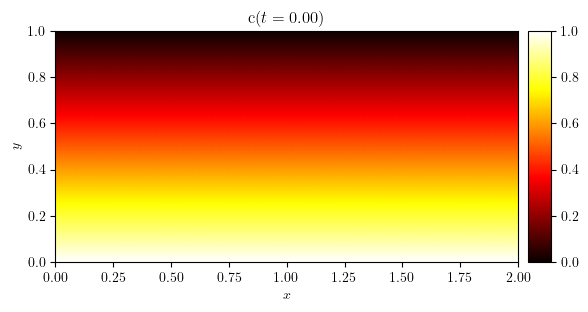

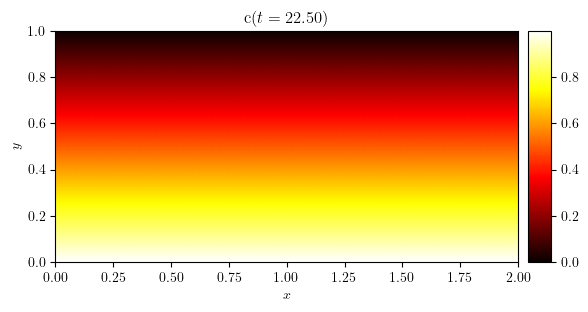

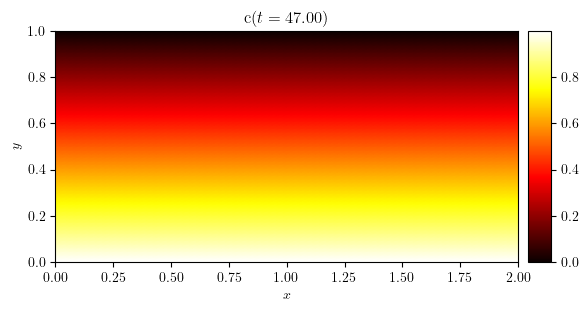

In [5]:
c = simulation['c']

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'c($t={c.time_series[i]:.2f})$')
    # write(fig, f'A08_rayleigh_benard_t={c.time_series[i]:.2f}')